In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models
import numpy as np
import os
from sklearn.metrics import accuracy_score
import pandas as pd
from torchvision.models import (ResNet50_Weights, VGG11_Weights, MobileNet_V2_Weights, ConvNeXt_Tiny_Weights, GoogLeNet_Weights)

In [2]:
print(torchvision.__version__)
print(torch.__version__)

0.20.0+cu124
2.5.0+cu124


In [3]:
base_dir = '/kaggle/input/trainingdataset/Food24K_Split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 54


In [13]:
class BaseModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(BaseModel, self).__init__()
        if model_name == "resnet50":
            self.model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
            self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Override the fc layer

        elif model_name == "vgg11":
            self.model = models.vgg11(weights=VGG11_Weights.DEFAULT)
            self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)  # Override the classifier

        elif model_name == "mobilenet_v2":
            self.model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
            self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)  # Override the classifier

        elif model_name == "convnext_tiny":
            self.model = models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
            self.model.classifier[2] = nn.Linear(self.model.classifier[2].in_features, num_classes)  # Override the classifier

        elif model_name == "googlenet":
            self.model = models.googlenet(weights=GoogLeNet_Weights.DEFAULT)
            self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Override the fc layer

        else:
            raise ValueError("Invalid model name")

    def forward(self, x):
        return self.model(x)

class MetaModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MetaModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)
        

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = BaseModel("resnet50", 10).to(DEVICE)
model2 = BaseModel("vgg11", 10).to(DEVICE)
# model3 = BaseModel("mobilenet_v2", num_classes).to(DEVICE)
# model4 = BaseModel("googlenet", num_classes).to(DEVICE)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\vgg11-8a719046.pth
100%|██████████| 507M/507M [00:31<00:00, 16.8MB/s] 


In [14]:
model2

BaseModel(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel_siz

In [4]:
print(model1)

BaseModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [10]:
class CustomResNet(nn.Module):
    def __init__(self, base_model):
        super(CustomResNet, self).__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten output để dùng cho metamodel
        return x


# Khởi tạo mô hình mới
custom_model = CustomResNet(model1.model)
print(custom_model)

CustomResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

In [11]:
dummy_input = torch.randn(4, 3, 224, 224).to(DEVICE)
output = custom_model(dummy_input)

# Kiểm tra kích thước đầu ra
print("Kích thước đầu ra:", output.shape)

Kích thước đầu ra: torch.Size([4, 2048])


In [5]:
def save_model(model, model_name):
    os.makedirs("saved_models", exist_ok=True)
    save_path = os.path.join("saved_models", f"{model_name}_weights.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Model weights saved to {save_path}")

def train_model(model, train_loader, val_loader, epochs=EPOCHS, learning_rate=LEARNING_RATE):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies

# Dictionary to store results for each model
model_results = {}

# Train models and collect results
models = {
    "ResNet50": model1,
    "VGG11": model2,
    "MobileNetV2": model3,
    "GoogLeNet": model4
}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader)
    save_model(model, model_name.lower().replace(' ', '_'))
    model_results[model_name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies
    }

Training ResNet50...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10, Train Loss: 2.3402, Val Loss: 1.0252, Val Accuracy: 72.33%
Epoch 2/10, Train Loss: 0.9454, Val Loss: 0.6143, Val Accuracy: 82.68%
Epoch 3/10, Train Loss: 0.7043, Val Loss: 0.5487, Val Accuracy: 84.05%
Epoch 4/10, Train Loss: 0.5853, Val Loss: 0.5082, Val Accuracy: 85.24%
Epoch 5/10, Train Loss: 0.5110, Val Loss: 0.5201, Val Accuracy: 86.20%
Epoch 6/10, Train Loss: 0.4500, Val Loss: 0.5053, Val Accuracy: 86.07%
Epoch 7/10, Train Loss: 0.4167, Val Loss: 0.4903, Val Accuracy: 86.26%
Epoch 8/10, Train Loss: 0.3811, Val Loss: 0.4836, Val Accuracy: 86.97%
Epoch 9/10, Train Loss: 0.3538, Val Loss: 0.4724, Val Accuracy: 86.65%
Epoch 10/10, Train Loss: 0.3328, Val Loss: 0.4850, Val Accuracy: 86.97%
Model weights saved to saved_models/resnet50_weights.pth
Training VGG11...
Epoch 1/10, Train Loss: 2.3210, Val Loss: 1.2728, Val Accuracy: 64.36%
Epoch 2/10, Train Loss: 1.4518, Val Loss: 1.0827, Val Accuracy: 68.72%
Epoch 3/10, Train Loss: 1.2068, Val Loss: 0.9409, Val Accuracy: 72.91%
E

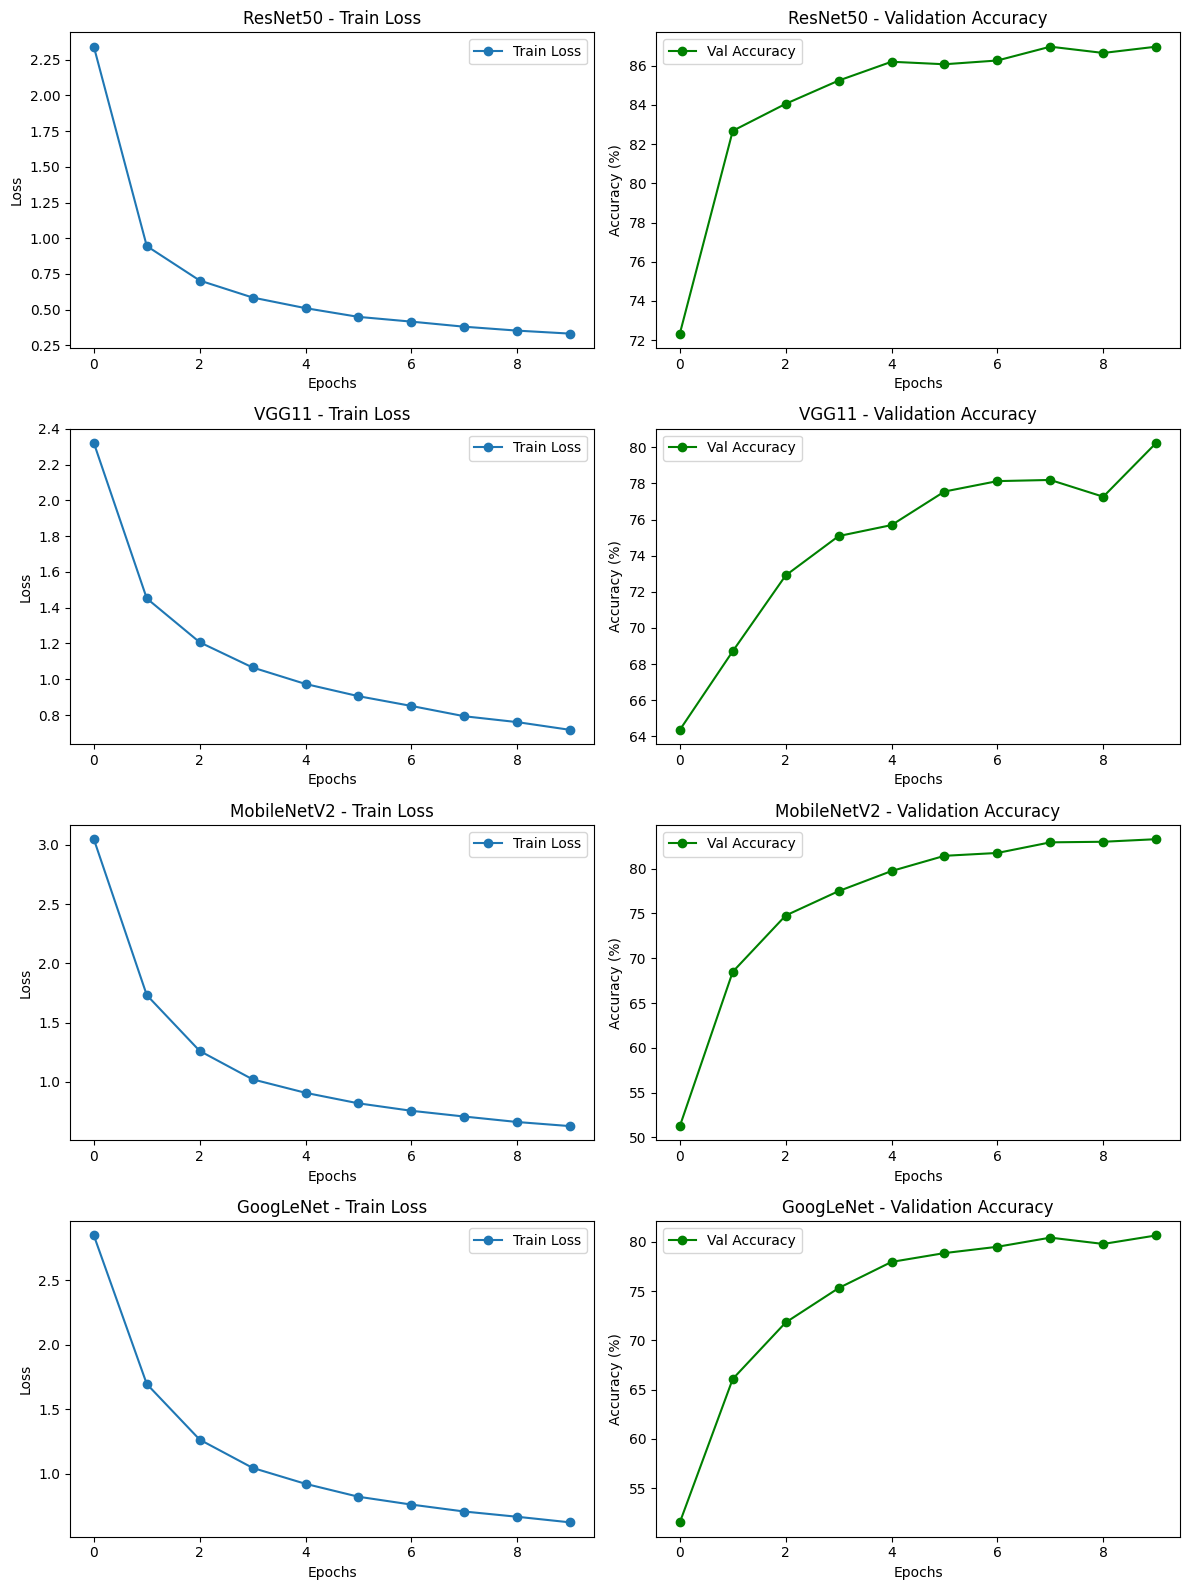

In [6]:
import matplotlib.pyplot as plt

num_models = len(models)
fig, axes = plt.subplots(num_models, 2, figsize=(12, 4 * num_models))

if num_models == 1:
    axes = [axes]  # Ensure axes is iterable when there's only one model

for i, (model_name, results) in enumerate(model_results.items()):
    train_losses = results["train_losses"]
    val_accuracies = results["val_accuracies"]

    # Plot Train Loss
    axes[i][0].plot(train_losses, label="Train Loss", marker="o")
    axes[i][0].set_title(f"{model_name} - Train Loss")
    axes[i][0].set_xlabel("Epochs")
    axes[i][0].set_ylabel("Loss")
    axes[i][0].legend()

    # Plot Validation Accuracy
    axes[i][1].plot(val_accuracies, label="Val Accuracy", marker="o", color="green")
    axes[i][1].set_title(f"{model_name} - Validation Accuracy")
    axes[i][1].set_xlabel("Epochs")
    axes[i][1].set_ylabel("Accuracy (%)")
    axes[i][1].legend()

plt.tight_layout()
plt.show()

In [7]:
def create_meta_features(models, loader):
    meta_features = []
    true_labels = []

    for images, labels in loader:
        images = images.to(DEVICE)
        outputs = []
        for model in models:
            model.eval()
            with torch.no_grad():
                output = model(images)
                outputs.append(output)
        outputs = torch.cat(outputs, dim=1)
        meta_features.append(outputs)
        true_labels.append(labels)

    meta_features = torch.cat(meta_features)
    true_labels = torch.cat(true_labels)
    print(f"Meta features shape: {meta_features.shape}, True labels shape: {true_labels.shape}")
    return meta_features, true_labels



#  Test model
# dummy_loader = [
#     (torch.randn(4, 3, 224, 224), torch.randint(0, num_classes, (4,)))
# ]
# Extract meta-features for the validation set
# meta_features, meta_labels = create_meta_features([model1, model2, model3, model4, model5], dummy_loader)
# print(meta_features.shape)
# print(meta_labels.shape)

meta_features, meta_labels = create_meta_features([model1, model2, model3, model4], val_loader)

Meta features shape: torch.Size([3123, 216]), True labels shape: torch.Size([3123])


### Train MetaModels

In [8]:
def train_meta_model(meta_model, meta_features, meta_labels):
    EPOCHS = 40
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(meta_model.parameters(), lr=LEARNING_RATE)

    for epoch in range(EPOCHS):
        meta_model.train()
        optimizer.zero_grad()
        outputs = meta_model(meta_features)
        loss = criterion(outputs, meta_labels)
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {loss.item():.4f}")


input_size = meta_features.shape[1] 
meta_model = MetaModel(input_size=input_size, num_classes=num_classes).to(DEVICE)


# Train MetaModel
print("Training MetaModel...")
meta_features = meta_features.to(DEVICE)
meta_labels = meta_labels.to(DEVICE)
train_meta_model(meta_model, meta_features, meta_labels)

Training MetaModel...
Epoch 1/40, Train Loss: 5.0683
Epoch 2/40, Train Loss: 5.0083
Epoch 3/40, Train Loss: 4.9691
Epoch 4/40, Train Loss: 4.8589
Epoch 5/40, Train Loss: 4.8142
Epoch 6/40, Train Loss: 4.7563
Epoch 7/40, Train Loss: 4.6985
Epoch 8/40, Train Loss: 4.5803
Epoch 9/40, Train Loss: 4.5441
Epoch 10/40, Train Loss: 4.5049
Epoch 11/40, Train Loss: 4.4371
Epoch 12/40, Train Loss: 4.4117
Epoch 13/40, Train Loss: 4.3322
Epoch 14/40, Train Loss: 4.2744
Epoch 15/40, Train Loss: 4.2436
Epoch 16/40, Train Loss: 4.1880
Epoch 17/40, Train Loss: 4.1833
Epoch 18/40, Train Loss: 4.1322
Epoch 19/40, Train Loss: 4.0794
Epoch 20/40, Train Loss: 4.0467
Epoch 21/40, Train Loss: 3.9894
Epoch 22/40, Train Loss: 3.9732
Epoch 23/40, Train Loss: 3.9567
Epoch 24/40, Train Loss: 3.9198
Epoch 25/40, Train Loss: 3.8570
Epoch 26/40, Train Loss: 3.8731
Epoch 27/40, Train Loss: 3.8141
Epoch 28/40, Train Loss: 3.7891
Epoch 29/40, Train Loss: 3.7499
Epoch 30/40, Train Loss: 3.7357
Epoch 31/40, Train Loss: 3.

In [9]:
# Extract meta-features for the test set
test_meta_features, test_meta_labels = create_meta_features([model1, model2, model3, model4], test_loader)
test_meta_features = test_meta_features.to(DEVICE)
test_meta_labels = test_meta_labels.to(DEVICE)
def evaluate_stacking_model(meta_model, test_features, test_labels):
    meta_model.eval()
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        test_outputs = meta_model(test_features)
        test_loss = criterion(test_outputs, test_labels)
        _, test_preds = torch.max(test_outputs, 1)
        accuracy = (test_preds == test_labels).float().mean()
    return accuracy


# Evaluate test accuracy using the stacking model
test_accuracy_stacking = evaluate_stacking_model(meta_model, test_meta_features, test_meta_labels)
print(f"Stacking Model Test Accuracy: {test_accuracy_stacking.item() * 100:.2f}%")

Meta features shape: torch.Size([3191, 216]), True labels shape: torch.Size([3191])
Stacking Model Test Accuracy: 27.95%
